## **MASTER'S DEGREE IN APPLIED ARTIFICIAL INTELLIGENCE.**

**Course:** TC5035.10 - Integration project

**Tecnológico de Monterrey**

**Professor:** Dra. Grettel Barceló Alonso

**Provessor:** Dr. Luis Eduardo Falcón Morales

**Advisory Professor:** María de la Paz Rico Fernández

### **Week 4, Activity 2**

FE - Feature Engineering

###**Team 12:**

Luis Ángel Seda Marcos
A01795301@tec.mx

Christopher Flores González
A01795419@tec.mx

Luis Felipe Nicanor Gutiérrez
A01795631@tec.mx

In [ ]:
# Installing scikit-learn to ensure required preprocessing and dimensionality reduction tools are available.

!pip install scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: C:\Users\Angel\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [ ]:
# Importing essential libraries for data manipulation, visualization, and feature engineering.
# pandas and numpy for data handling
# sklearn for scaling and PCA
# matplotlib and seaborn for plotting
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

## Introduction

This notebook focuses on the feature engineering phase of a machine learning project, following the CRISP-ML methodology. The process involves:

*   **Loading the dataset**: The initial data containing clips features is loade that was generated during our EDA.
*   **Standardization**: Landmark coordinates are standardized to ensure all features are on a similar scale, which is crucial for many machine learning algorithms.
*   **Structuring the data**: The data is restructured to have a fixed number of frames (120) per clip, either by repeating the last frame for shorter clips or truncating longer ones.
*   **Flattening the data**: The frame-based landmark data is flattened into a single row per clip, preparing it for subsequent analysis or modeling.
*   **Dimensionality Reduction (PCA)**: Principal Component Analysis is applied to reduce the dimensionality of the flattened landmark data, mitigating the curse of dimensionality and potentially improving model performance.

In [ ]:
# Loading the extracted features from dynamic sign language clips.
# This dataset includes metadata and 3D hand landmark coordinates.
clips_features_df = pd.read_csv('../../src/files/clips_features.csv')


In [ ]:

# Displaying the first few rows to understand the structure and verify successful loading.
print(clips_features_df.head())


          clip_id class_id signer_id     view  repetition  \
0  S1-J-frontal-1        J        S1  frontal           1   
1  S1-J-frontal-1        J        S1  frontal           1   
2  S1-J-frontal-1        J        S1  frontal           1   
3  S1-J-frontal-1        J        S1  frontal           1   
4  S1-J-frontal-1        J        S1  frontal           1   

                                                path  split   fps  n_frames  \
0  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
1  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
2  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
3  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
4  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   

   duration  ...      z_17      x_18      y_18      z_18      x_19      y_19  \
0  2.066667  ...  0.010676  0.533660  0.346997  0.000967  0.521835  0.319036  

In [ ]:
# Checking data types and null values to assess data quality and completeness.
print(clips_features_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84347 entries, 0 to 84346
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   clip_id          84347 non-null  object 
 1   class_id         84347 non-null  object 
 2   signer_id        84347 non-null  object 
 3   view             84347 non-null  object 
 4   repetition       84347 non-null  int64  
 5   path             84347 non-null  object 
 6   split            84347 non-null  object 
 7   fps              84347 non-null  float64
 8   n_frames         84347 non-null  int64  
 9   duration         84347 non-null  float64
 10  width            84347 non-null  int64  
 11  height           84347 non-null  int64  
 12  file_size        84347 non-null  int64  
 13  brightness_mean  84347 non-null  float64
 14  brightness_std   84347 non-null  float64
 15  blur_mean        84347 non-null  float64
 16  frame_id         84347 non-null  float64
 17  x_0         

# **Step 1:** Normalize all landmark coordinates (x, y, z) to standardize scale across features.
This step ensures that the coordinates are in the correct range for any subsequent models.

In [ ]:
scaler = StandardScaler()

In [ ]:
# Selecting all landmark coordinate columns for normalization (21 landmarks).
landmark_columns = [f'x_{i}' for i in range(21)] + [f'y_{i}' for i in range(21)] + [f'z_{i}' for i in range(21)]


## Standard Scaling Landmark Coordinates

Standard scaling (using `StandardScaler`) was applied to all landmark coordinate columns (x, y, and z for each of the 21 landmarks) to ensure consistent feature ranges for modeling. This decision was made for several important reasons:

1.  **Algorithm Sensitivity**: Many machine learning algorithms, especially those based on distance calculations (like K-Nearest Neighbors, Support Vector Machines, and algorithms that use gradient descent), are highly sensitive to the scale of the input features. If features have vastly different ranges, those with larger ranges can disproportionately influence the model's results, potentially leading to suboptimal performance.

2.  **Equal Feature Contribution**: By standardizing the landmark coordinates to have a mean of 0 and a standard deviation of 1, we ensure that each coordinate (x, y, and z) and each landmark contributes equally to the model, regardless of their original scale. This prevents features with larger numerical values from dominating the learning process.

3.  **Improved Convergence**: For iterative optimization algorithms used in many machine learning models, standardizing features can lead to faster convergence to the optimal solution.

4.  **Preparation for PCA**: PCA is also sensitive to feature scaling. Standardizing the landmark coordinates before applying PCA ensures that the principal components are influenced by the variance across all features equally, rather than being dominated by features with larger scales.

In summary, applying standard scaling to all landmark coordinate columns is a crucial preprocessing step that prepares the data for effective use in various machine learning algorithms by ensuring that all features are on a comparable scale and contribute appropriately to the modeling process.

In [ ]:
# Applying standard scaling to ensure consistent feature ranges for modeling.
clips_features_df[landmark_columns] = scaler.fit_transform(clips_features_df[landmark_columns])


In [ ]:
print(clips_features_df.describe)

<bound method NDFrame.describe of               clip_id class_id signer_id     view  repetition  \
0      S1-J-frontal-1        J        S1  frontal           1   
1      S1-J-frontal-1        J        S1  frontal           1   
2      S1-J-frontal-1        J        S1  frontal           1   
3      S1-J-frontal-1        J        S1  frontal           1   
4      S1-J-frontal-1        J        S1  frontal           1   
...               ...      ...       ...      ...         ...   
84342   S9-Ñ-perfil-5        Ñ        S9  profile           5   
84343   S9-Ñ-perfil-5        Ñ        S9  profile           5   
84344   S9-Ñ-perfil-5        Ñ        S9  profile           5   
84345   S9-Ñ-perfil-5        Ñ        S9  profile           5   
84346   S9-Ñ-perfil-5        Ñ        S9  profile           5   

                                                    path  split     fps  \
0      ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.000   
1      ..\..\src\datasets\MSL-dynam

# **Step 2:** Restructure landmark coordinates into grouped columns.
Each landmark will be represented as a list of [x, y, z].

In [ ]:
new_columns = []
for i in range(21):  # 21 landmarks
    new_columns.append(f'landmark_{i}')  # Name for the column of each landmark

# Create a DataFrame with the landmark values ​​(x, y, z)
landmark_data = []
for i in range(21):
    # Create a list for each landmark, which will have the 3 coordinates
    landmark_data.append(
        clips_features_df[[f'x_{i}', f'y_{i}', f'z_{i}']].values.tolist()
    )
# Creating a new DataFrame where each column represents a landmark with its 3D coordinates.
landmark_df = pd.DataFrame({
    f'landmark_{i}': [coords for coords in clips_features_df[[f'x_{i}', f'y_{i}', f'z_{i}']].values]
    for i in range(21)
})

print(landmark_df.head())

                                          landmark_0  \
0  [-0.4736259075945064, -0.22314232696808164, -1...   
1  [-0.4680353138670269, -0.21628949270819756, -0...   
2  [-0.4610939589800419, -0.19094895108712442, -0...   
3  [-0.4747923813878494, -0.1867630933938315, -1....   
4  [-0.47446417048129885, -0.18001909874409608, -...   

                                          landmark_1  \
0  [-0.387069635037375, -0.2540830944637174, -0.6...   
1  [-0.36709137018307314, -0.24998056400889088, -...   
2  [-0.3595529483188028, -0.23278045042033704, -0...   
3  [-0.3802502490397703, -0.23493335591761128, -0...   
4  [-0.3765377089053991, -0.2278799215229258, -0....   

                                          landmark_2  \
0  [-0.2830191424270885, -0.4857626616535488, -0....   
1  [-0.2670874437487096, -0.5018447661350157, -0....   
2  [-0.2710075631499034, -0.49638489769090666, -0...   
3  [-0.2791506437944434, -0.4835184407854786, -0....   
4  [-0.2763176195412786, -0.48413027357509136,

# **Step 3:** Merge original metadata with newly structured landmark columns.
Creates a unified dataset for each frame. Keep the video metadata (clip_id, etc.) and merge it with the new landmarks columns

In [ ]:

final_df = pd.concat([clips_features_df.drop(columns=landmark_columns), landmark_df], axis=1)

In [ ]:
print(final_df.head())

          clip_id class_id signer_id     view  repetition  \
0  S1-J-frontal-1        J        S1  frontal           1   
1  S1-J-frontal-1        J        S1  frontal           1   
2  S1-J-frontal-1        J        S1  frontal           1   
3  S1-J-frontal-1        J        S1  frontal           1   
4  S1-J-frontal-1        J        S1  frontal           1   

                                                path  split   fps  n_frames  \
0  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
1  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
2  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
3  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
4  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   

   duration  ...                                        landmark_11  \
0  2.066667  ...  [-0.20940889860284767, -1.172991880090486, 0.6...   
1  2.066667  ...

In [ ]:
final_df.describe

<bound method NDFrame.describe of               clip_id class_id signer_id     view  repetition  \
0      S1-J-frontal-1        J        S1  frontal           1   
1      S1-J-frontal-1        J        S1  frontal           1   
2      S1-J-frontal-1        J        S1  frontal           1   
3      S1-J-frontal-1        J        S1  frontal           1   
4      S1-J-frontal-1        J        S1  frontal           1   
...               ...      ...       ...      ...         ...   
84342   S9-Ñ-perfil-5        Ñ        S9  profile           5   
84343   S9-Ñ-perfil-5        Ñ        S9  profile           5   
84344   S9-Ñ-perfil-5        Ñ        S9  profile           5   
84345   S9-Ñ-perfil-5        Ñ        S9  profile           5   
84346   S9-Ñ-perfil-5        Ñ        S9  profile           5   

                                                    path  split     fps  \
0      ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.000   
1      ..\..\src\datasets\MSL-dynam

# **Step 4:** Truncate or pad each clip to exactly 120 frames.
Ensures uniform input length for downstream models.

In [ ]:
def truncate_frames(df, max_frames=120):
    # If the number of frames is less than max_frames, repeat the last frame
    if len(df) < max_frames:
        last_row = df.iloc[-1:]
        df = pd.concat([df] + [last_row]*(max_frames - len(df)), ignore_index=True)
    # If the number of frames is greater than max_frames, truncate the DataFrame
    elif len(df) > max_frames:
        df = df.iloc[:max_frames]
    return df

# Applies truncation and resets the index
final_df_adjusted = (
    final_df.groupby('clip_id', group_keys=False)
    .apply(truncate_frames)
    .reset_index(drop=True)
)

C:\Users\Angel\AppData\Local\Temp\ipykernel_9396\3153714096.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(truncate_frames)


In [ ]:
# Verifying that each clip now contains exactly 120 frames.
print(final_df_adjusted['clip_id'].value_counts())

clip_id
S9-Ñ-perfil-5     120
S1-J-frontal-1    120
S1-J-frontal-2    120
S1-J-frontal-3    120
S9-Z-frontal-4    120
                 ... 
S1-J-perfil-4     120
S1-J-perfil-3     120
S1-J-perfil-2     120
S1-J-perfil-1     120
S1-J-frontal-5    120
Name: count, Length: 1108, dtype: int64


In [ ]:
# Applying truncation function to each clip and resetting index.
# Assuming 'clip_id' is the video identifier
final_df_adjusted = final_df.groupby('clip_id').apply(truncate_frames)

C:\Users\Angel\AppData\Local\Temp\ipykernel_9396\2210155505.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df_adjusted = final_df.groupby('clip_id').apply(truncate_frames)


In [ ]:
print(final_df_adjusted.describe)

<bound method NDFrame.describe of                            clip_id class_id signer_id     view  repetition  \
clip_id                                                                      
S1-J-frontal-1 0    S1-J-frontal-1        J        S1  frontal           1   
               1    S1-J-frontal-1        J        S1  frontal           1   
               2    S1-J-frontal-1        J        S1  frontal           1   
               3    S1-J-frontal-1        J        S1  frontal           1   
               4    S1-J-frontal-1        J        S1  frontal           1   
...                            ...      ...       ...      ...         ...   
S9-Ñ-perfil-5  115   S9-Ñ-perfil-5        Ñ        S9  profile           5   
               116   S9-Ñ-perfil-5        Ñ        S9  profile           5   
               117   S9-Ñ-perfil-5        Ñ        S9  profile           5   
               118   S9-Ñ-perfil-5        Ñ        S9  profile           5   
               119   S9-Ñ-perf

# **Step 5:** Visualize the distribution of a specific landmark coordinate (x of landmark_0).
Helps assess feature variability and detect outliers. Display the distribution of one of the generated features, for example, the first coordinate 'landmark_0_x'

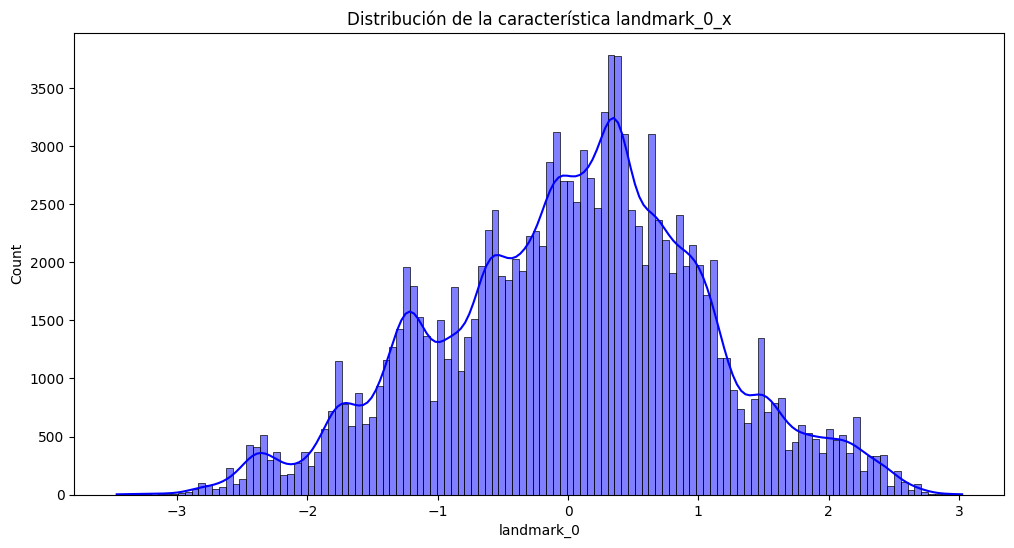

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(final_df_adjusted['landmark_0'].apply(lambda x: x[0]), kde=True, color='blue')
plt.title('Distribución de la característica landmark_0_x')
plt.show()

# **Step 6:** Flatten the landmark data across frames.
Converts each clip into a single row with all landmark coordinates across time.

In [ ]:
final_df_adjusted = final_df.groupby('clip_id').apply(truncate_frames).reset_index(drop=True)

C:\Users\Angel\AppData\Local\Temp\ipykernel_9396\3356132941.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df_adjusted = final_df.groupby('clip_id').apply(truncate_frames).reset_index(drop=True)


In [ ]:
meta_columns = [col for col in final_df_adjusted.columns if not col.startswith('landmark_')]

flattened_rows = []

for clip_id, group in final_df_adjusted.groupby('clip_id'):
    row_dict = group.iloc[0][meta_columns].to_dict()

    # Iterate over the 120 frames
    for frame_idx, (_, frame) in enumerate(group.iterrows(), 1):  # frame_idx from 1 to 120
        # Iterate on the 21 landmarks
        for lm_idx in range(21):
            coords = frame[f'landmark_{lm_idx}']  # This is a list [x,y,z]
            # Save each coordinate as a separate feature
            row_dict[f'landmark_{lm_idx}_frame_{frame_idx}_x'] = coords[0]
            row_dict[f'landmark_{lm_idx}_frame_{frame_idx}_y'] = coords[1]
            row_dict[f'landmark_{lm_idx}_frame_{frame_idx}_z'] = coords[2]

    flattened_rows.append(row_dict)

In [ ]:
# Create Pivoted Final DataFrame
pivot_df = pd.DataFrame(flattened_rows)

print(pivot_df.head())
print(f"Pivoted DataFrame shape: {pivot_df.shape}")

          clip_id class_id signer_id     view  repetition  \
0  S1-J-frontal-1        J        S1  frontal           1   
1  S1-J-frontal-2        J        S1  frontal           2   
2  S1-J-frontal-3        J        S1  frontal           3   
3  S1-J-frontal-4        J        S1  frontal           4   
4  S1-J-frontal-5        J        S1  frontal           5   

                                                path  split   fps  n_frames  \
0  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
1  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        48   
2  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
3  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        63   
4  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        76   

   duration  ...  landmark_17_frame_120_z  landmark_18_frame_120_x  \
0  2.066667  ...                -0.792228                 0.580819   
1  1.600000  ...  

In [ ]:
# Saving the flattened dataset to CSV for future use in modeling or analysis.
pivot_df.to_csv('../../src/files/clips_features_flattened.csv', index=False)
print(f"clips_features_flattened.csv generated with {pivot_df.shape[0]} rows y {pivot_df.shape[1]} columns")


clips_features_flattened.csv generated with 1108 rows y 7577 columns


In [ ]:
flattened_rows = []

for clip_id, group in final_df_adjusted.groupby('clip_id'):
    row_dict = group.iloc[0][meta_columns].to_dict()
    # Iterate over the frames
    for frame_idx, (_, frame) in enumerate(group.iterrows(), 1):  # frame_idx from 1 to 120
        # Iterate over the landmarks
        for lm_idx in range(21):
            # We save the complete list [x, y, z] without separating
            row_dict[f'landmark_{lm_idx}_frame_{frame_idx}'] = frame[f'landmark_{lm_idx}']
    flattened_rows.append(row_dict)

# Create pivoted final DataFrame
pivot_df = pd.DataFrame(flattened_rows)

print(pivot_df.head())
print(f"Pivoted DataFrame shape: {pivot_df.shape}")

          clip_id class_id signer_id     view  repetition  \
0  S1-J-frontal-1        J        S1  frontal           1   
1  S1-J-frontal-2        J        S1  frontal           2   
2  S1-J-frontal-3        J        S1  frontal           3   
3  S1-J-frontal-4        J        S1  frontal           4   
4  S1-J-frontal-5        J        S1  frontal           5   

                                                path  split   fps  n_frames  \
0  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
1  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        48   
2  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
3  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        63   
4  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        76   

   duration  ...                              landmark_11_frame_120  \
0  2.066667  ...  [0.7887094898199172, -1.7337228772705662, 0.21...   
1  1.600000  ...

In [ ]:
# Save CSV
pivot_df.to_csv('../../src/files/clips_features_flattened_list.csv', index=False)
print(f"clips_features_flattened_list.csv generated with {pivot_df.shape[0]} rows y {pivot_df.shape[1]} columns")

clips_features_flattened_list.csv generated with 1108 rows y 2537 columns


In [ ]:
n_components = 250  # Number of principal components you want

In [ ]:
# --------------------------
# Process clips_features_flattened_list.csv
# --------------------------
df_list = pd.read_csv('../../src/files/clips_features_flattened_list.csv')
print(df_list.head())

          clip_id class_id signer_id     view  repetition  \
0  S1-J-frontal-1        J        S1  frontal           1   
1  S1-J-frontal-2        J        S1  frontal           2   
2  S1-J-frontal-3        J        S1  frontal           3   
3  S1-J-frontal-4        J        S1  frontal           4   
4  S1-J-frontal-5        J        S1  frontal           5   

                                                path  split   fps  n_frames  \
0  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
1  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        48   
2  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
3  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        63   
4  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        76   

   duration  ...                  landmark_11_frame_120  \
0  2.066667  ...  [ 0.78870949 -1.73372288  0.21315523]   
1  1.600000  ...  [ 0.91013862 -2.063292

In [ ]:
# Columns meta
meta_columns = [col for col in df_list.columns if not col.startswith('landmark_')]
# Columns landmarks
landmark_columns = [col for col in df_list.columns if col.startswith('landmark_')]

After flattening the frame-based data for each clip, creating a pivoted DataFrame is crucial to consolidate all the features for a single clip into a single row. Each row in the final pivoted DataFrame represents one complete video clip, and the columns represent all the flattened landmark coordinates across all the frames, along with the original metadata for the clip. This structure is the standard input format for most machine learning algorithms.

# **Step 7:** Apply PCA to reduce dimensionality of the flattened list format.
Converts 2537 features into 250 principal components.

In [ ]:
# Convert lists [x,y,z] of columns to array
expanded_data = []
for col in landmark_columns:
    coords_array = df_list[col].apply(lambda x: np.fromstring(x.strip('[]'), sep=',') if isinstance(x, str) else np.array(x)).to_list()
    expanded_data.append(np.vstack(coords_array))
X_list = np.hstack(expanded_data)

C:\Users\Angel\AppData\Local\Temp\ipykernel_9396\2063592292.py:4: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  coords_array = df_list[col].apply(lambda x: np.fromstring(x.strip('[]'), sep=',') if isinstance(x, str) else np.array(x)).to_list()


Principal Component Analysis (PCA) was chosen for dimensionality reduction for several key reasons:

1.  **Reducing the Curse of Dimensionality**: The flattened landmark data has a very high number of features (7577 columns). High-dimensional data can lead to increased computational complexity, longer training times, and a higher risk of overfitting in machine learning models. PCA helps mitigate this by transforming the data into a lower-dimensional space while retaining most of the variance.

2.  **Noise Reduction**: High-dimensional data often contains noise. PCA filters out some of this noise by focusing on the components that capture the most significant variance in the data.

3.  **Improving Model Performance**: By reducing the number of features and potentially removing noise, PCA can lead to simpler models that are less prone to overfitting and may generalize better to unseen data. This can result in improved model accuracy and efficiency.

4.  **Visualisation**: Although not explicitly shown, PCA can be useful for visualizing high-dimensional data in 2 or 3 dimensions, which can help in understanding the data structure and identifying patterns.

In this specific case, with 7577 features in the flattened data, PCA provides a powerful method to significantly reduce the feature space to a more manageable size (250 components) while aiming to preserve the most important information for subsequent analysis or modeling.

In [ ]:

# Saving PCA-transformed dataset for efficient model training.

pca = PCA(n_components=n_components)
X_list_pca = pca.fit_transform(X_list)

# Create DataFrame of PCA
pca_columns = [f'PCA_{i+1}' for i in range(n_components)]
pca_df_list = pd.DataFrame(X_list_pca, columns=pca_columns)

# Concatenate metadata
final_df_list = pd.concat([df_list[meta_columns].reset_index(drop=True), pca_df_list], axis=1)

# Save CSV
final_df_list.to_csv('../../src/files/clips_features_flattened_list_pca.csv', index=False)
print(f"../../src/files/clips_features_flattened_list_pca.csv generated with {final_df_list.shape[0]} rows y {final_df_list.shape[1]} columns")

../../src/files/clips_features_flattened_list_pca.csv generated with 1108 rows y 267 columns


In [ ]:
# --------------------------
# Process clips_features_flattened.csv
# --------------------------
df_flat = pd.read_csv('../../src/files/clips_features_flattened.csv')
print(df_flat.head())

          clip_id class_id signer_id     view  repetition  \
0  S1-J-frontal-1        J        S1  frontal           1   
1  S1-J-frontal-2        J        S1  frontal           2   
2  S1-J-frontal-3        J        S1  frontal           3   
3  S1-J-frontal-4        J        S1  frontal           4   
4  S1-J-frontal-5        J        S1  frontal           5   

                                                path  split   fps  n_frames  \
0  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
1  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        48   
2  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        62   
3  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        63   
4  ..\..\src\datasets\MSL-dynamic-signs\train\S1-...  train  30.0        76   

   duration  ...  landmark_17_frame_120_z  landmark_18_frame_120_x  \
0  2.066667  ...                -0.792228                 0.580819   
1  1.600000  ...  

# **Step 8:** Apply PCA to the flattened format with separated x/y/z columns.
Reduces 7577 features to 250 components.

In [ ]:
# Columns meta
meta_columns_flat = [col for col in df_flat.columns if not col.startswith('landmark_')]
# Columns landmarks (x,y,z)
landmark_columns_flat = [col for col in df_flat.columns if col.startswith('landmark_')]
X_flat = df_flat[landmark_columns_flat].values

In [ ]:
# Saving PCA-transformed dataset with separated coordinates.

pca_flat = PCA(n_components=n_components)
X_flat_pca = pca_flat.fit_transform(X_flat)

# Create PCA DataFrame
pca_columns_flat = [f'PCA_{i+1}' for i in range(n_components)]
pca_df_flat = pd.DataFrame(X_flat_pca, columns=pca_columns_flat)

# Concatenate metadata
final_df_flat = pd.concat([df_flat[meta_columns_flat].reset_index(drop=True), pca_df_flat], axis=1)

# Save CSV
final_df_flat.to_csv('../../src/files/clips_features_flattened_pca.csv', index=False)
print(f"clips_features_flattened_pca.csv generated with {final_df_flat.shape[0]} rows y {final_df_flat.shape[1]} columns")


clips_features_flattened_pca.csv generated with 1108 rows y 267 columns


# Conclusion

This notebook performs structured feature engineering on dynamic sign language clips using hand landmarks. The process includes:

1. **Normalization** of 3D coordinates to ensure consistent scale.
2. **Restructuring** landmarks into grouped columns for clarity.
3. **Frame truncation** to standardize clip length at 120 frames.
4. **Flattening** the temporal data to create a single-row representation per clip.
5. **Dimensionality reduction** via PCA to optimize for model efficiency.

These steps are essential to prepare high-dimensional temporal data for machine learning tasks such as gesture classification. By ensuring uniformity, reducing noise, and compressing features, we enable robust and scalable modeling.

The final outputs include:
- A flattened dataset with full temporal resolution.
- Two PCA-reduced datasets for modeling efficiency.

This pipeline supports future integration with classifiers and deep learning models, and is designed to be reproducible, interpretable, and scalable.
